# Task X: Diffusion
Complete the specific task 2 from the DeepFalcon test. Comment on potential ideas to extend this classical diffusion architecture to a quantum diffusion and sketch out the architecture in detail.




---



---



#Installing Requirements

In [12]:
# Install required packages
!pip install -q tqdm h5py scikit-image matplotlib

import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
import os
import time
import gc
import warnings
warnings.filterwarnings("ignore")


torch.manual_seed(42)
np.random.seed(42)


### 🔍 JetDataset: Custom PyTorch Dataset Class

This class wraps the raw dataset (such as jet images) in a PyTorch-friendly format.
- `__init__`: Stores the input data.
- `__len__`: Returns the total number of samples.
- `__getitem__`: Returns one sample at a given index, which is used when loading data in batches.

This structure is essential for enabling PyTorch `DataLoader` to handle shuffling, batching, and efficient data loading.


In [13]:
class JetDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

### 📥 load_data: Load and Preprocess Jet Dataset from HDF5

This function performs the following:
- Opens the `.h5` file and prints the available keys and their shapes.
- Loads a maximum of 10,000 jet samples (`X_jets`) and their corresponding labels (`y`) to avoid memory issues.
- Handles various input shapes:
  - Automatically rearranges the channel dimensions if needed (e.g., from NHWC to NCHW).
- Optionally downsamples images to **32×32** if larger, using bilinear interpolation.
- Normalizes each channel of the jet images by dividing by the max value in that channel.
- Returns the processed data and labels as NumPy arrays of type `float32` and `int64`, respectively.


In [14]:
def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        print("Keys in the HDF5 file:", list(f.keys()))

        for key in f.keys():
            print(f"{key} shape: {f[key].shape}")

        max_samples = 10000

        total_samples = f['X_jets'].shape[0]
        print(f"Total samples available: {total_samples}")

        n_samples = min(max_samples, total_samples)
        print(f"Using {n_samples} samples to prevent memory issues")

        X_jets = np.array(f['X_jets'][:n_samples])
        labels = np.array(f['y'][:n_samples])

    print(f"X_jets loaded shape: {X_jets.shape}")

    if len(X_jets.shape) == 4:
        if X_jets.shape[1] == 3:
            data = X_jets
        elif X_jets.shape[-1] == 3:
            data = np.transpose(X_jets, (0, 3, 1, 2))
        else:
            print(f"Non-standard channel dimension detected: {X_jets.shape}")
            if X_jets.shape[1] < 10:
                data = X_jets
            else:
                data = np.transpose(X_jets, (0, 3, 1, 2))
    else:
        print("WARNING: Unexpected dimensions in X_jets. Using as is.")
        data = X_jets

    print(f"Final data shape: {data.shape}")

    if data.shape[2] > 32 or data.shape[3] > 32:
        downsample_size = (32, 32)
        print(f"Downsampling images from {data.shape[2]}x{data.shape[3]} to {downsample_size[0]}x{downsample_size[1]}")
        downsampled_data = []

        for i in range(data.shape[0]):
            channels = []
            for c in range(data.shape[1]):
                img = data[i, c]
                resized = torch.nn.functional.interpolate(
                    torch.tensor(img).unsqueeze(0).unsqueeze(0),
                    size=downsample_size,
                    mode='bilinear',
                    align_corners=False
                ).squeeze().numpy()
                channels.append(resized)
            downsampled_data.append(np.array(channels))

        data = np.array(downsampled_data)
        print(f"Downsampled data shape: {data.shape}")

    for i in range(data.shape[1]):
        channel_max = np.max(data[:, i])
        if channel_max > 0:
            data[:, i] = data[:, i] / channel_max

    data = data.astype(np.float32)
    labels = labels.astype(np.int64)

    return data, labels

### 🧠 SimpleDiffusionCNN: A Basic CNN for Diffusion-Based Denoising

This neural network is designed for denoising images using a simple encoder–decoder structure with time-step conditioning for diffusion models.

#### Architecture Overview:
- **Time Embedding (`time_emb`)**:
  - Maps the scalar timestep `t` into a learned embedding to condition the network on the diffusion process.
  
- **Encoder:**
  - `enc1`: Standard 2D convolution layer to extract features from the input.
  - `enc2`: Downsamples the feature map using strided convolution (acts like pooling while learning).

- **Middle (Latent) Layer:**
  - `mid`: Processes the latent representation.
  - `mid_time`: Adds the time embedding to the latent representation to condition it.

- **Decoder:**
  - `dec1`: Transposed convolution (upsampling) to reconstruct the spatial resolution.
  - `dec2`: Final convolution to bring the output back to the original input channel size.

- **Activation Function:**
  - Uses ReLU activation (`self.act`) after most layers to add non-linearity.

#### Forward Pass:
1. Embed the timestep.
2. Encode the input image into a lower-resolution feature map.
3. Fuse the time embedding into the latent space.
4. Decode the features back into the original image shape.

This model outputs the denoised image corresponding to a given noisy input and timestep.


In [15]:
class SimpleDiffusionCNN(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=16):
        super().__init__()

        self.time_emb = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU()
        )

        self.enc1 = nn.Conv2d(in_channels, hidden_dim, 3, padding=1)
        self.enc2 = nn.Conv2d(hidden_dim, hidden_dim*2, 4, stride=2, padding=1)

        self.mid = nn.Conv2d(hidden_dim*2, hidden_dim*2, 3, padding=1)
        self.mid_time = nn.Linear(hidden_dim, hidden_dim*2)

        self.dec1 = nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 4, stride=2, padding=1)
        self.dec2 = nn.Conv2d(hidden_dim, in_channels, 3, padding=1)

        self.act = nn.ReLU()

    def forward(self, x, t):
        t_emb = self.time_emb(t.unsqueeze(-1))

        x1 = self.act(self.enc1(x))
        x2 = self.act(self.enc2(x1))

        mid = self.mid(x2)
        t_out = self.mid_time(t_emb).unsqueeze(-1).unsqueeze(-1)
        mid = mid + t_out
        mid = self.act(mid)

        x = self.act(self.dec1(mid))
        x = self.dec2(x)

        return x

### 🌫️ DiffusionModel: Core Diffusion Process Class

This class encapsulates both the **forward (noise addition)** and **reverse (denoising)** processes of the diffusion model. It manages the timestep schedule, noise sampling, loss computation, and sampling during generation.

#### 🔧 `__init__`:
- Initializes the linear noise schedule using `betas` over `n_steps`.
- Computes:
  - `alphas = 1 - beta`
  - `alpha_bars = cumulative product of alphas`, which is used in both forward and reverse steps.

#### 🔄 `forward_diffusion(x0, t)`:
- Adds noise to the original data `x0` at timestep `t`:
  - Uses the closed-form formula:  
   
  - Returns the noisy data `x_t` and the noise `ε`.

#### 🎲 `sample_timesteps(n)`:
- Randomly samples `n` timesteps for training, uniformly between `0` and `n_steps - 1`.

#### 🏋️ `train_step(x, optimizer)`:
- Performs one training step:
  1. Samples random timesteps `t`.
  2. Generates noisy data `x_t` from `x_0`.
  3. Predicts the noise `ε` using the model.
  4. Computes MSE loss between true and predicted noise.
  5. Backpropagates and updates the model.

#### 🧪 `generate(shape)`:
- Runs the reverse denoising process starting from pure noise.
- Iteratively denoises from `x_T` to `x_0` using the learned noise predictor.
- Applies the DDPM update rule at each timestep:
  
  where `z` is Gaussian noise (except at `t = 0`).


In [16]:
class DiffusionModel:
    def __init__(self, model, beta_start=1e-4, beta_end=0.02, n_steps=50, device="cuda"):
        self.model = model
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.n_steps = n_steps
        self.device = device

        self.betas = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def forward_diffusion(self, x0, t):
        alpha_bar = self.alpha_bars[t]
        alpha_bar = alpha_bar.reshape(-1, 1, 1, 1)

        epsilon = torch.randn_like(x0)

        return torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * epsilon, epsilon

    def sample_timesteps(self, n):
        return torch.randint(low=0, high=self.n_steps, size=(n,)).to(self.device)

    def train_step(self, x, optimizer):
        optimizer.zero_grad()

        t = self.sample_timesteps(x.shape[0])

        x_noisy, noise = self.forward_diffusion(x, t)

        pred_noise = self.model(x_noisy, t.float() / self.n_steps)

        loss = F.mse_loss(pred_noise, noise)

        loss.backward()
        optimizer.step()

        del x_noisy, noise, pred_noise, t
        torch.cuda.empty_cache()

        return loss.item()

    @torch.no_grad()
    def generate(self, shape):
        x = torch.randn(shape).to(self.device)

        sampling_steps = self.n_steps

        for t in tqdm(reversed(range(sampling_steps)), total=sampling_steps):
            time_tensor = torch.ones(shape[0], dtype=torch.float, device=self.device) * t / self.n_steps

            pred_noise = self.model(x, time_tensor)

            alpha = self.alphas[t]
            alpha_bar = self.alpha_bars[t]
            beta = self.betas[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = 1 / torch.sqrt(alpha) * (x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * pred_noise) + torch.sqrt(beta) * noise

            del pred_noise, noise, time_tensor
            torch.cuda.empty_cache()

        return x



### 🏋️‍♀️ Training Loop: `train_diffusion_model(...)`

This function wraps the training loop for the diffusion model, taking care of both **training** and **validation** over multiple epochs.

#### 🔑 Parameters:
- `model`: Neural network used to predict noise.
- `train_loader`, `val_loader`: Data loaders for training and validation datasets.
- `n_epochs`: Number of epochs to train (default: 5).
- `lr`: Learning rate for the Adam optimizer.
- `device`: Device to run on (default: "cuda").

#### 🔁 Core Workflow:
1. Initialize:
   - The model and optimizer.
   - A `DiffusionModel` instance to manage noise scheduling and training steps.
   - Containers to store training and validation losses.

2. **Training Loop**:
   - For each batch:
     - Perform a diffusion training step using `DiffusionModel.train_step()`.
     - Accumulate loss over 50 batches per epoch for training speed.

3. **Validation Loop**:
   - For each batch:
     - Sample timesteps and perform the forward diffusion process.
     - Predict noise using the model.
     - Compute MSE loss against actual noise.
     - Only validate on 10 batches per epoch for faster experimentation.

4. **Model Saving**:
   - On the final epoch, save model weights, optimizer state, and losses.

#### 📤 Returns:
- `train_losses`: List of average training loss per epoch.
- `val_losses`: List of average validation loss per epoch.
- `diffusion`: The `DiffusionModel` instance (useful for sampling later).


In [17]:
def train_diffusion_model(model, train_loader, val_loader, n_epochs=5, lr=1e-4, device="cuda"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    diffusion = DiffusionModel(model, device=device, n_steps=50)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        batch_count = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Training"):
            batch = batch.to(device)
            loss = diffusion.train_step(batch, optimizer)
            epoch_loss += loss
            batch_count += 1

            del batch
            torch.cuda.empty_cache()

            if batch_count >= 50:
                break

        avg_train_loss = epoch_loss / batch_count
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        val_count = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Validation"):
                batch = batch.to(device)
                t = diffusion.sample_timesteps(batch.shape[0])
                x_noisy, noise = diffusion.forward_diffusion(batch, t)
                pred_noise = model(x_noisy, t.float() / diffusion.n_steps)
                loss = F.mse_loss(pred_noise, noise)
                val_loss += loss.item()
                val_count += 1

                del batch, x_noisy, noise, pred_noise, t
                torch.cuda.empty_cache()

                if val_count >= 10:
                    break

        avg_val_loss = val_loss / val_count
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if epoch == n_epochs - 1:
            model_path = f"diffusion_model_final.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss
            }, model_path)
            print(f"Model saved to {model_path}")

        gc.collect()
        torch.cuda.empty_cache()

    return train_losses, val_losses, diffusion


### 🧪 Evaluation: `evaluate_diffusion_model(...)`

This function evaluates the quality of images generated by the diffusion model using visual and quantitative metrics.

#### 🔑 Parameters:
- `diffusion`: A trained `DiffusionModel` instance.
- `test_data`: Test samples as a NumPy array or torch tensor (e.g., images).
- `device`: CUDA or CPU device to run the generation.
- `num_samples`: Number of samples from test data to evaluate (default: 4).

#### 🚦 Workflow:
1. **Preprocess Input**:
   - Select the first `num_samples` from `test_data`.
   - Convert to float and move to device.

2. **Generate Samples**:
   - Use `diffusion.generate()` to produce reconstructed versions.
   - Record time taken for generation.

3. **Compute Metrics**:
   - **SSIM (Structural Similarity Index)**:
     - Computed per channel and averaged across channels.
     - If an image channel has a constant value, SSIM is either 1.0 or 0.0.
   - **MSE (Mean Squared Error)**:
     - Measures the pixel-wise difference between original and generated.
   - **PSNR (Peak Signal-to-Noise Ratio)**:
     - Higher values indicate more similarity; useful for assessing image fidelity.

4. **Clean Up**:
   - Delete large tensors to save memory.
   - Clear CUDA cache.

#### 📤 Returns:
A dictionary containing:
- `ssim`: Average SSIM score across all evaluated images.
- `mse`: Mean Squared Error.
- `psnr`: Peak Signal-to-Noise Ratio.
- `original`: Numpy array of original images.
- `generated`: Numpy array of generated images.
- `generation_time`: Total time (in seconds) taken to generate the samples.


In [18]:
def evaluate_diffusion_model(diffusion, test_data, device="cuda", num_samples=4):
    test_data = test_data[:num_samples]
    test_data = torch.tensor(test_data, dtype=torch.float).to(device)

    start_time = time.time()
    generated_samples = diffusion.generate(test_data.shape)
    generation_time = time.time() - start_time

    original = test_data.cpu().numpy()
    generated = generated_samples.cpu().numpy()

    del test_data, generated_samples
    torch.cuda.empty_cache()

    ssim_scores = []
    for i in range(len(original)):
        ssim_score = 0
        for channel in range(original.shape[1]):
            if np.max(original[i, channel]) == np.min(original[i, channel]):
                channel_ssim = 1.0 if np.array_equal(original[i, channel], generated[i, channel]) else 0.0
            else:
                channel_ssim = ssim(original[i, channel], generated[i, channel],
                                    data_range=np.max(original[i, channel]) - np.min(original[i, channel]))
            ssim_score += channel_ssim
        ssim_scores.append(ssim_score / original.shape[1])

    average_ssim = np.mean(ssim_scores)

    mse = np.mean((original - generated) ** 2)

    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) if mse > 0 else 100

    return {
        'ssim': average_ssim,
        'mse': mse,
        'psnr': psnr,
        'original': original,
        'generated': generated,
        'generation_time': generation_time
    }


## 📊 Visualization and Evaluation Metrics

After training and evaluating the diffusion model, it's essential to **visually inspect** the quality of generated samples and **track the training progress**.

---

### 🎨 `visualize_results(results, num_samples=4)`

This function visualizes a side-by-side comparison of the **original vs. generated images** for a few samples.

#### 🔍 Key Features:
- Supports **multi-channel images** (e.g., ECAL, HCAL, Track).
- Shows side-by-side plots for each channel per sample.
- Saves the figure as `diffusion_results_comparison.png`.

#### 🧠 Also prints:
- `SSIM`: Structural similarity score (closer to 1 = better).
- `MSE`: Mean squared error (lower is better).
- `PSNR`: Peak signal-to-noise ratio (higher is better).
- Generation time for the samples.

---

### 📈 `plot_training_history(train_losses, val_losses)`

Plots the training and validation loss curves over epochs.

#### ✅ Use it to:
- Check for **overfitting or underfitting**.
- Ensure loss is decreasing smoothly.
- Compare how training vs. validation loss behaves.

#### 💾 Output:
- Saves the plot as `training_history.png`.


In [19]:
def visualize_results(results, num_samples=4):
    num_samples = min(num_samples, len(results['original']))

    n_channels = results['original'].shape[1]

    fig, axes = plt.subplots(num_samples, 2*n_channels, figsize=(3*n_channels, 2.5*num_samples))

    channel_names = [f"Channel {i+1}" for i in range(n_channels)]

    for i in range(num_samples):
        for c in range(n_channels):
            if num_samples > 1:
                ax_orig = axes[i, c]
            else:
                ax_orig = axes[c]

            ax_orig.imshow(results['original'][i, c], cmap='viridis')
            ax_orig.set_title(f'Original {channel_names[c]}')
            ax_orig.axis('off')

            if num_samples > 1:
                ax_gen = axes[i, c + n_channels]
            else:
                ax_gen = axes[c + n_channels]

            ax_gen.imshow(results['generated'][i, c], cmap='viridis')
            ax_gen.set_title(f'Generated {channel_names[c]}')
            ax_gen.axis('off')

    plt.tight_layout()
    plt.savefig('diffusion_results_comparison.png')
    plt.show()

    print("\n--- Evaluation Metrics ---")
    print(f"SSIM: {results['ssim']:.4f} (higher is better, max is 1)")
    print(f"MSE: {results['mse']:.6f} (lower is better)")
    print(f"PSNR: {results['psnr']:.4f} dB (higher is better)")
    print(f"Generation Time: {results['generation_time']:.2f} seconds for {len(results['original'])} samples")


def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Diffusion Model Training History')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_history.png')
    plt.show()


## 🚀 Complete Workflow Pipeline

The `main()` function ties together the **entire workflow** of training and evaluating a diffusion model for jet image generation. Here's a summary of what happens step-by-step:

---

### 🔁 `main()` Function Pipeline

#### 1. **Setup**
- Sets the device (`cuda` if available).
- Loads the full dataset from the HDF5 file.

#### 2. **Preprocessing**
- Splits the data into **train**, **validation**, and **test** sets (90/10/10 split).
- Wraps train and validation data into a custom PyTorch `JetDataset`.
- Prepares DataLoaders for batching and shuffling.

#### 3. **Model Initialization**
- Creates a **lightweight CNN model** (`SimpleDiffusionCNN`) tailored for the diffusion task.

#### 4. **Training**
- Calls `train_diffusion_model()` to run the training loop with diffusion steps.
- Collects and plots **training vs. validation loss** for performance tracking.

#### 5. **Evaluation**
- Uses `evaluate_diffusion_model()` on the test split to:
  - Generate new samples.
  - Compare them with real images.
  - Compute SSIM, MSE, PSNR, and generation time.

#### 6. **Visualization**
- Calls `visualize_results()` to show original vs. generated images, per channel.
- Evaluation metrics are printed for each run.

---

### 🏁 Output Artifacts:
- 📉 `training_history.png`: Train/Val loss curve.
- 🖼️ `diffusion_results_comparison.png`: Original vs. generated image grid.
- ✅ Evaluation metrics (SSIM, MSE, PSNR, generation time).
- 💾 Model checkpoint (`diffusion_model_final.pt`).

> This wraps up a minimal, testable diffusion pipeline for jet image generation.


Using device: cpu
Loading data...
Keys in the HDF5 file: ['X_jets', 'm0', 'pt', 'y']
X_jets shape: (139306, 125, 125, 3)
m0 shape: (139306,)
pt shape: (139306,)
y shape: (139306,)
Total samples available: 139306
Using 10000 samples to prevent memory issues
X_jets loaded shape: (10000, 125, 125, 3)
Final data shape: (10000, 3, 125, 125)
Downsampling images from 125x125 to 32x32
Downsampled data shape: (10000, 3, 32, 32)
Splitting data into train/validation/test sets...
Creating extremely simplified model for diffusion...
Training diffusion model...


Epoch 1/5 - Validation:   4%|▍         | 9/225 [00:00<00:00, 260.20it/s]


Epoch 1/5, Train Loss: 1.0035, Val Loss: 0.9990


Epoch 2/5 - Validation:   4%|▍         | 9/225 [00:00<00:00, 232.61it/s]


Epoch 2/5, Train Loss: 0.9961, Val Loss: 0.9961


Epoch 3/5 - Validation:   4%|▍         | 9/225 [00:00<00:00, 260.00it/s]


Epoch 3/5, Train Loss: 0.9905, Val Loss: 0.9777


Epoch 4/5 - Validation:   4%|▍         | 9/225 [00:00<00:01, 147.49it/s]


Epoch 4/5, Train Loss: 0.9738, Val Loss: 0.9564


Epoch 5/5 - Validation:   4%|▍         | 9/225 [00:00<00:01, 195.62it/s]


Epoch 5/5, Train Loss: 0.9339, Val Loss: 0.9076
Model saved to diffusion_model_final.pt


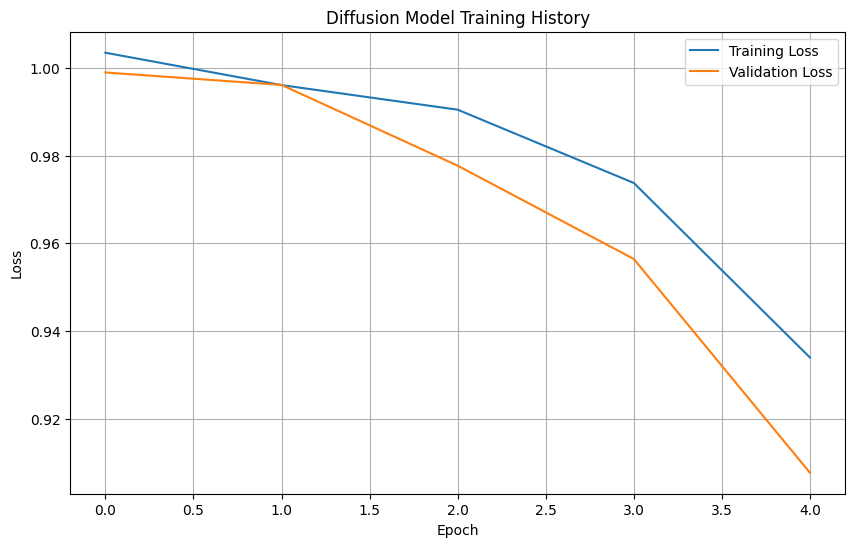

Evaluating model...


100%|██████████| 50/50 [00:00<00:00, 191.78it/s]


Visualizing results...


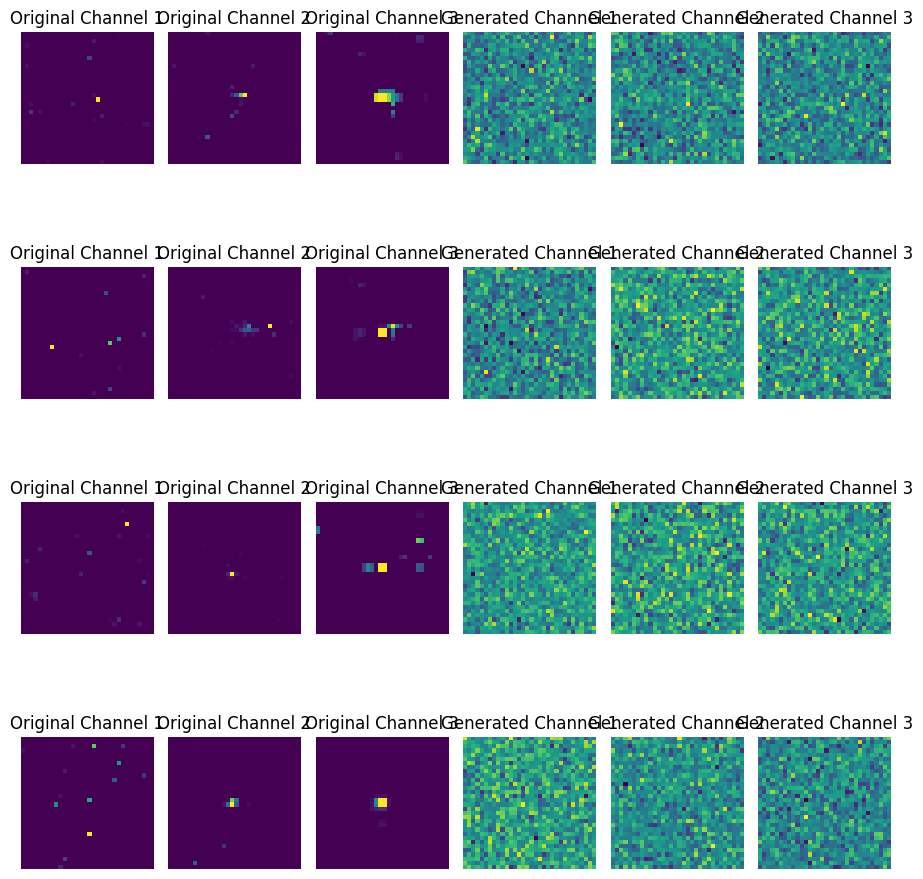


--- Evaluation Metrics ---
SSIM: -0.0000 (higher is better, max is 1)
MSE: 1.952730 (lower is better)
PSNR: -2.9064 dB (higher is better)
Generation Time: 0.27 seconds for 4 samples
Task completed successfully!


In [20]:
def main():
    file_path ='/content/quark-gluon_data-set_n139306.hdf5'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    batch_size = 4
    n_epochs = 5

    print("Loading data...")
    data, labels = load_data(file_path)

    gc.collect()
    torch.cuda.empty_cache()

    print("Splitting data into train/validation/test sets...")
    train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

    train_dataset = JetDataset(torch.tensor(train_data, dtype=torch.float))
    val_dataset = JetDataset(torch.tensor(val_data, dtype=torch.float))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=False)

    del data, train_data, val_data
    gc.collect()
    torch.cuda.empty_cache()


    print("Creating extremely simplified model for diffusion...")
    model = SimpleDiffusionCNN(in_channels=train_dataset.data.shape[1], hidden_dim=16)

    print("Training diffusion model...")
    train_losses, val_losses, diffusion = train_diffusion_model(
        model, train_loader, val_loader, n_epochs=n_epochs, device=device
    )


    plot_training_history(train_losses, val_losses)


    print("Evaluating model...")
    results = evaluate_diffusion_model(diffusion, test_data, device=device, num_samples=4)


    print("Visualizing results...")
    visualize_results(results, num_samples=4)

    print("Task completed successfully!")

if __name__ == "__main__":
    main()

# 🌀 Quantum Diffusion Models: Conceptual Framework
Quantum diffusion models are a hybrid generative modeling approach that combine:

Classical diffusion processes (forward and reverse)

With quantum parameterized circuits (PQC) for modeling the data distribution and learning the reverse process.

They're especially interesting because:

Quantum circuits can represent highly expressive probability distributions.

Quantum noise (inherent to quantum measurements) mirrors the stochastic nature of diffusion.



---



---



# 🌪️ Core Idea: From Noise to Data
**In classical diffusion models:**
*   You slowly add noise to data (forward process).
*   Then train a model to reverse this noise step-by-step to recover the data (reverse process).

**In Quantum Diffusion**:
*   You start from quantum noise states (e.g., maximally mixed or specific initialized quantum states).
*   You train quantum or hybrid models to learn reverse transformations that map noisy quantum states to data-like states.


---



---





# 🧠 Key Components
**1. Forward Process (Quantum or Classical)**:
Gradually corrupt the data:
*   Classical → Quantum Encoding: Convert classical data (e.g., images) into quantum states.
*  Add noise at each step
𝑡
 either via:

Classical noise to image → then re-encode quantumly.

Quantum noise channels: Use depolarizing, dephasing, amplitude damping, etc., on quantum states.



**Example (Quantum noise for forward step):**




In [ ]:
!pip install qiskit

In [6]:
def add_quantum_noise(circuit, p):
    noise = depolarizing_error(p, 1)
    circuit.barrier()
    for q in circuit.qubits:
        circuit.append(noise.to_instruction(), [q])



---



---



# 2. Reverse Process (Learned by Quantum Network)
Learn to reverse noise: from a noisy quantum state at step
𝑡
, predict the "less noisy" state at
𝑡
−
1
.

**You use a parameterized quantum circuit (PQC) or quantum-classical hybrid model to do this.**

In [7]:
def reverse_model_pqc(num_qubits, depth):
    params = ParameterVector('θ', length=depth * num_qubits * 2)
    qc = QuantumCircuit(num_qubits)
    k = 0
    for d in range(depth):
        for i in range(num_qubits):
            qc.ry(params[k], i)
            k += 1
            qc.rz(params[k], i)
            k += 1
        for i in range(num_qubits - 1):
            qc.cx(i, i + 1)
    return qc

During training, you measure certain qubits (or extract expectation values) to predict denoised values.


---




---



### 🧮 3. Loss Function: Denoising Score Matching

In quantum diffusion models, we use the **denoising score matching loss** adapted for quantum hybrid networks:

$$
\mathcal{L} = \mathbb{E}_{x, t, \epsilon} \left[ \left\| \epsilon - \epsilon_\theta(x_t, t) \right\|^2 \right]
$$

Where:

- **$x_t$**: Noisy version of the original input $x$ at time step $t$
- **$\epsilon$**: True noise added during the forward diffusion process
- **$\epsilon_\theta(x_t, t)$**: Model’s prediction of the noise using a parameterized quantum circuit (PQC) or hybrid quantum-classical network

💡 **Note**:  
If the PQC output is **probabilistic**, compute the expectation value from measurements to estimate $\epsilon_\theta$.

Example (pseudocode):

```python
# Assume `measurements` is an array of outcomes from PQC
epsilon_theta = np.mean(measurements, axis=0)

# Mean squared error loss
loss = np.mean((epsilon - epsilon_theta)**2)


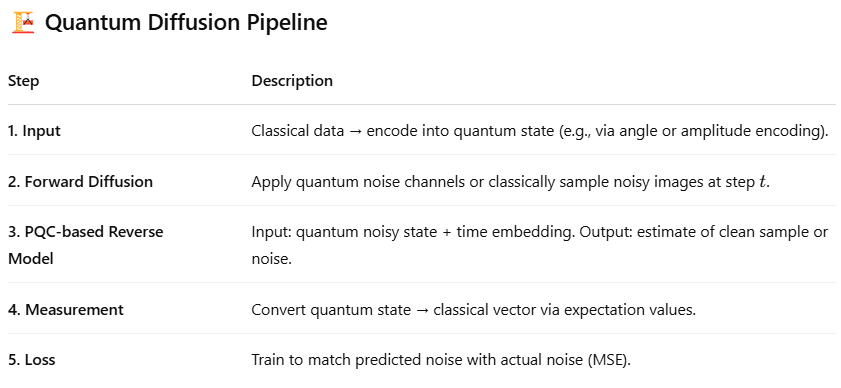




---


---

